In [1]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)

# This is needed for the iterator over the data
# But not necessary if you have TF 2.0 installed
#!pip install tensorflow==2.0.0-beta0


tf.enable_eager_execution()

# !pip install -q tensorflow-datasets

C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

1.14.0


C:\Users\User\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:5

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print("")
print(training_sentences[1])

b i saw this film on true movies which automatically made me <OOV> but actually it was good why not because of the amazing plot twists or breathtaking dialogue of which there is little but because actually despite what people say i thought the film was accurate in it's depiction of teenagers dealing with <OOV> br br it's not <OOV> creek they're not <OOV> cool witty characters who <OOV> through sexuality with <OOV> knowledge they're kids and they act like kids would br br they're blunt awkward and annoyingly confused about everything yes this could be by accident and they could just be bad actors but i don't think so <OOV> <OOV> gives when not trying to be cool a

b"I saw this film on True Movies (which automatically made me sceptical) but actually - it was good. Why? Not because of the amazing plot twists or breathtaking dialogue (of which there is little) but because actually, despite what people say I thought the film was accurate in it's depiction of teenagers dealing with pregnancy

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


## normal fit and save the whole model

In [7]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), verbose=2)

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
25000/25000 - 5s - loss: 0.4879 - acc: 0.7506 - val_loss: 0.3441 - val_acc: 0.8470
Epoch 2/10
25000/25000 - 3s - loss: 0.2437 - acc: 0.9063 - val_loss: 0.3659 - val_acc: 0.8402
Epoch 3/10
25000/25000 - 3s - loss: 0.0999 - acc: 0.9734 - val_loss: 0.4586 - val_acc: 0.8225
Epoch 4/10
25000/25000 - 3s - loss: 0.0270 - acc: 0.9962 - val_loss: 0.5267 - val_acc: 0.8253
Epoch 5/10
25000/25000 - 3s - loss: 0.0077 - acc: 0.9992 - val_loss: 0.5950 - val_acc: 0.8250
Epoch 6/10
25000/25000 - 3s - loss: 0.0024 - acc: 0.9999 - val_loss: 0.6471 - val_acc: 0.8248
Epoch 7/10
25000/25000 - 3s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.6912 - val_acc: 0.8270
Epoch 8/10
25000/25000 - 3s - loss: 5.0486e-04 - acc: 1.0000 - val_loss: 0.7364 - val_acc: 0.8266
Epoch 9/10
25000/25000 - 3s - loss: 2.9342e-04 - acc: 1.0000 - val_loss: 0.7693 - val_acc: 0.8271
Epoch 10/10
25000/25000 - 4s - loss: 1.7582e-04 - acc: 1.0000 - val_loss: 0.8062 - val_acc: 0.8266


In [8]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [9]:
# Save the entire model as a SavedModel.
model.save('saved_model/my_model') 

In [10]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

# Re-evaluate the model
loss,acc = model.evaluate(testing_padded, testing_labels_final, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________
25000/25000 - 1s - loss: 0.8062 - acc: 0.8266
Restored model, accuracy: 82.66%


## plot

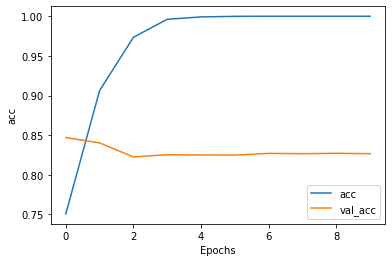

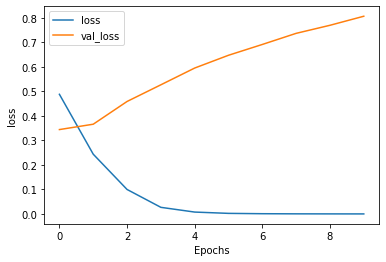

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Test new case

In [12]:
sentences = ['I really think this is amazing. honest.',
             "it's wasting time.",
             'the best of this year!',
             'yearly junk',
             'read the book, instead of going to cinema',
             'your kids will love it!',
             'the effect is cheap.']
sequence = tokenizer.texts_to_sequences(sentences)
print(sequence)
r = model.predict(pad_sequences(sequence, maxlen = max_length, padding = 'post', truncating = trunc_type))
for u, v in list(zip(sentences, r)):
    rating = 'Good' if v[0] > 0.5 else 'Bad'
    print(f'{u} → {rating}')

[[11, 68, 105, 12, 7, 490, 1216], [103, 3160, 60], [2, 120, 5, 12, 281], [1, 2613], [337, 2, 274, 306, 5, 168, 6, 437], [131, 357, 81, 119, 10], [2, 971, 7, 716]]
I really think this is amazing. honest. → Good
it's wasting time. → Bad
the best of this year! → Good
yearly junk → Bad
read the book, instead of going to cinema → Bad
your kids will love it! → Good
the effect is cheap. → Bad


## confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [14]:
predictions = model.predict(testing_padded)
print(predictions[:20])

[[9.9790001e-01]
 [9.5298189e-01]
 [9.9999452e-01]
 [9.9997622e-01]
 [9.9964619e-01]
 [9.9995399e-01]
 [9.2576039e-01]
 [9.9999541e-01]
 [9.9906719e-01]
 [1.2475252e-04]
 [2.5580135e-01]
 [2.9521751e-01]
 [9.9999815e-01]
 [9.9873221e-01]
 [9.7755325e-01]
 [1.7583370e-05]
 [9.8670113e-01]
 [9.7182107e-01]
 [2.5329271e-01]
 [9.9992859e-01]]


In [15]:
rounded_predictions = model.predict_classes(testing_padded)
print(rounded_predictions[:20])

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]]


In [16]:
cm = confusion_matrix(testing_labels_final, rounded_predictions)
print(cm)

[[10394  2106]
 [ 2229 10271]]


In [17]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    #plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    plt.ylim([1.5, -0.5]) # solve squished issue
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix!")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i , cm[i, j],
                horizontalalignment="center",
                color = "white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10394  2106]
 [ 2229 10271]]


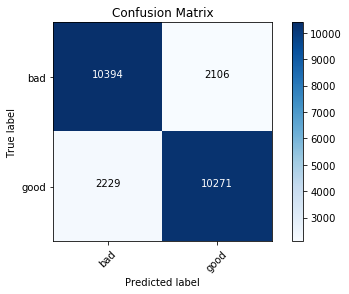

In [18]:
cm_plot_labels = ["bad", "good"]
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## io

In [19]:
"""
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
"""

'\nimport io\n\nout_v = io.open(\'vecs.tsv\', \'w\', encoding=\'utf-8\')\nout_m = io.open(\'meta.tsv\', \'w\', encoding=\'utf-8\')\nfor word_num in range(1, vocab_size):\n  word = reverse_word_index[word_num]\n  embeddings = weights[word_num]\n  out_m.write(word + "\n")\n  out_v.write(\'\t\'.join([str(x) for x in embeddings]) + "\n")\nout_v.close()\nout_m.close()\n'

In [20]:
"""
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')
"""

"\ntry:\n  from google.colab import files\nexcept ImportError:\n  pass\nelse:\n  files.download('vecs.tsv')\n  files.download('meta.tsv')\n  "

In [21]:
"""
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)
"""

'\nsentence = "I really think this is amazing. honest."\nsequence = tokenizer.texts_to_sequences(sentence)\nprint(sequence)\n'